# Thesis results - From data collected to graphs and insights

## Installing libraries for the Environment

In [25]:
!pip install pandas
!pip install IPython
!pip install numpy
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/28/ba/8be09886eb56ac04a218a1dc3fa728a5c4cac60b019b4f1687885166da00/matplotlib-3.9.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/05/46/9256dd162ea52790c127cb58cfc3b9e3413a6e3478917d1f811d420772ec/contourpy-1.3.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining de

## Data preparation

### Data access

As data was collected on three different systems, with four different CPU configurations testing five different tables, a list for each category is created, so that the code can be iterated easily.

In [58]:
tables = ["results_supplier_tpch_sf1", 
          "results_supplier_tpch_sf10",
          "results_supplier_tpch_sf100", 
          "results_lineitem_tpch_sf1", 
          "results_lineitem_tpch_sf10"]
number_of_rows = {"results_supplier_tpch_sf1": 10000, 
                  "results_supplier_tpch_sf10": 100000, 
                  "results_supplier_tpch_sf100": 1000000, 
                  "results_lineitem_tpch_sf1": 6000000, 
                  "results_lineitem_tpch_sf10": 60000000}
CPU_configs = ["1_core", "2_core", "4_core", "8_core"]
systems = ["HDFS", "LocalFS"] # Add "HUDI"
modes = ["read", "write"]

### Remove a column extra columns

The data collected from Snurran (production environment), gets saved with an extra column that contains the row number. This is not useful for data analysis purposes, so this column is removed.

In [ ]:
import pandas as pd
from IPython.display import display

for system in systems:
    for CPU_config in CPU_configs:
        for table in tables:
            # Read csv file
            df = pd.read_csv("/Users/gio-hopsworks/Developer/thesis-results/data/time/" + system + "/" + CPU_config + "/" + table + ".csv")
            display(df)
            # Select only Write and Read column
            df = df[['Write', 'Read']]
            # Save to .csv file without index
            df.to_csv("/Users/gio-hopsworks/Developer/thesis-results/data/time/" + system + "/" + CPU_config + "/" + table + ".csv", index=False)


### Calculate Throughput

In [60]:
for mode in modes:
    for system in systems:
        for CPU_config in CPU_configs:
            for table in tables:
                # Read csv file
                df = pd.read_csv("/Users/gio-hopsworks/Developer/thesis-results/data/time/" + system + "/" + CPU_config + "/" + table + ".csv")
                # Divide number of rows by the time saved in the dataframe
                df = df.rdiv(number_of_rows[table])
                # Save to .csv file without index
                df.to_csv("/Users/gio-hopsworks/Developer/thesis-results/data/throughput/" + system + "/" + CPU_config + "/" + table + ".csv", index=False)

## Calculate Mean Throughput per table with Confidence Interval

A table that for each row contains the mean and confidence interval of the thoughput of a table (table, CPU_config, system)

In [62]:
import numpy as np

import matplotlib.pyplot as plt 

In [63]:
def bootstrap(x, Nboot, statfun) :
    """ Calculate bootstrap statistics for a sample x """
    x = np.array(x)

    resampled_stat = []
    for k in range (Nboot) :
        index = np.random.randint(0, len(x), len(x))
        sample = x[index]
        resampled_stat.append(statfun(sample))
    
    return np.array(resampled_stat)

In [67]:
Nboot = 1000

for mode in modes:
    results = []
    for system in systems:
        for CPU_config in CPU_configs:
            for table in tables:
                # Read thoughput .csv file
                df = pd.read_csv("/Users/gio-hopsworks/Developer/thesis-results/data/throughput/" + system + "/" + CPU_config + "/" + table + ".csv")
                
                table_bootstrap = bootstrap(df[mode.capitalize()].to_numpy(), Nboot, np.mean)

                ## Save row of results in results
                results_row = [system, CPU_config, table, np.mean(table_bootstrap), np.percentile(table_bootstrap, 2.5), np.percentile(table_bootstrap, 97.5)]
                results.append(results_row)
    
    ## Create and then save a dataframe with the results in .csv
    df = pd.DataFrame(results, columns =  ["Technology", "CPU_Cores", "Table_name", "Mean", "Low_CI", "High_CI"])
    display(df)
    df.to_csv("/Users/gio-hopsworks/Developer/thesis-results/data/" + mode + "_results.csv", index=False)

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HDFS,1_core,results_supplier_tpch_sf1,3.306242e+05,3.092647e+05,3.522040e+05
1,HDFS,1_core,results_supplier_tpch_sf10,3.233949e+06,3.045030e+06,3.430538e+06
2,HDFS,1_core,results_supplier_tpch_sf100,3.526753e+07,3.305998e+07,3.749693e+07
3,HDFS,1_core,results_lineitem_tpch_sf1,1.890518e+08,1.770155e+08,2.019524e+08
4,HDFS,1_core,results_lineitem_tpch_sf10,1.929321e+09,1.829718e+09,2.039060e+09
5,HDFS,2_core,results_supplier_tpch_sf1,3.221538e+05,3.032372e+05,3.396180e+05
6,HDFS,2_core,results_supplier_tpch_sf10,3.696837e+06,3.499125e+06,3.882298e+06
7,HDFS,2_core,results_supplier_tpch_sf100,3.455219e+07,3.252851e+07,3.657060e+07
8,HDFS,2_core,results_lineitem_tpch_sf1,2.061597e+08,1.913307e+08,2.197965e+08
9,HDFS,2_core,results_lineitem_tpch_sf10,1.969130e+09,1.865274e+09,2.084007e+09


,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HDFS,1_core,results_supplier_tpch_sf1,8006.258324,7928.781770,8087.664381
1,HDFS,1_core,results_supplier_tpch_sf10,73587.792622,72056.374774,75940.391646
2,HDFS,1_core,results_supplier_tpch_sf100,106874.932243,105248.017805,108421.899054
3,HDFS,1_core,results_lineitem_tpch_sf1,305537.613692,299359.383530,311996.823048
4,HDFS,1_core,results_lineitem_tpch_sf10,339583.136763,334379.673106,344864.331897
5,HDFS,2_core,results_supplier_tpch_sf1,7931.301444,7857.912207,7999.567729
6,HDFS,2_core,results_supplier_tpch_sf10,77064.646699,75335.154092,79703.539206
7,HDFS,2_core,results_supplier_tpch_sf100,118068.585608,115707.233910,120284.612891
8,HDFS,2_core,results_lineitem_tpch_sf1,370920.697793,361866.486231,379977.376566
9,HDFS,2_core,results_lineitem_tpch_sf10,449466.409144,441593.178700,457354.246675


## Display results

### Write operations

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HDFS,1_core,results_supplier_tpch_sf1,8006.258324,7928.781770,8087.664381
1,HDFS,1_core,results_supplier_tpch_sf10,73587.792622,72056.374774,75940.391646
2,HDFS,1_core,results_supplier_tpch_sf100,106874.932243,105248.017805,108421.899054
3,HDFS,1_core,results_lineitem_tpch_sf1,305537.613692,299359.383530,311996.823048
4,HDFS,1_core,results_lineitem_tpch_sf10,339583.136763,334379.673106,344864.331897
5,LocalFS,1_core,results_supplier_tpch_sf1,259146.626608,249088.791230,268647.652611
6,LocalFS,1_core,results_supplier_tpch_sf10,673364.252376,644103.723273,702539.626589
7,LocalFS,1_core,results_supplier_tpch_sf100,119152.036352,117036.723075,120960.744356
8,LocalFS,1_core,results_lineitem_tpch_sf1,337823.621827,329748.668224,345757.673061
9,LocalFS,1_core,results_lineitem_tpch_sf10,349177.814021,344064.540563,354652.523406


/var/folders/3c/24cqpr7x4nl8cq9mscs0jtbm0000gp/T/ipykernel_70609/2765757706.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


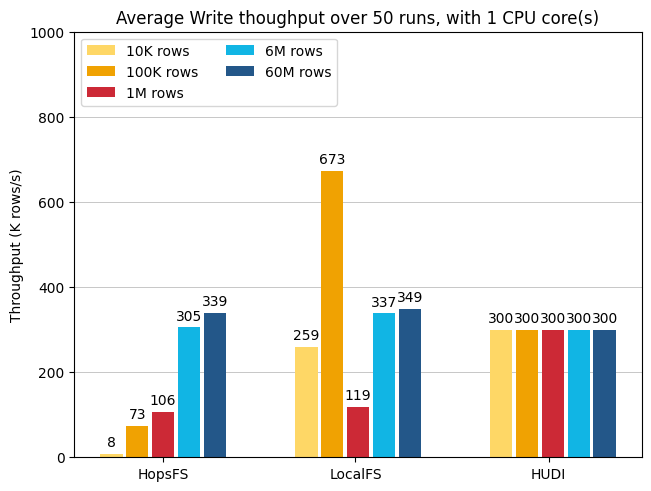

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HDFS,2_core,results_supplier_tpch_sf1,7931.301444,7857.912207,7999.567729
1,HDFS,2_core,results_supplier_tpch_sf10,77064.646699,75335.154092,79703.539206
2,HDFS,2_core,results_supplier_tpch_sf100,118068.585608,115707.233910,120284.612891
3,HDFS,2_core,results_lineitem_tpch_sf1,370920.697793,361866.486231,379977.376566
4,HDFS,2_core,results_lineitem_tpch_sf10,449466.409144,441593.178700,457354.246675
5,LocalFS,2_core,results_supplier_tpch_sf1,211245.044589,203021.152512,219813.440744
6,LocalFS,2_core,results_supplier_tpch_sf10,733734.372288,716681.514349,750045.332072
7,LocalFS,2_core,results_supplier_tpch_sf100,139980.770014,137173.032243,142514.775721
8,LocalFS,2_core,results_lineitem_tpch_sf1,396757.709094,386844.574994,408300.702332
9,LocalFS,2_core,results_lineitem_tpch_sf10,463844.331127,456064.591974,472492.979744


/var/folders/3c/24cqpr7x4nl8cq9mscs0jtbm0000gp/T/ipykernel_70609/2765757706.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


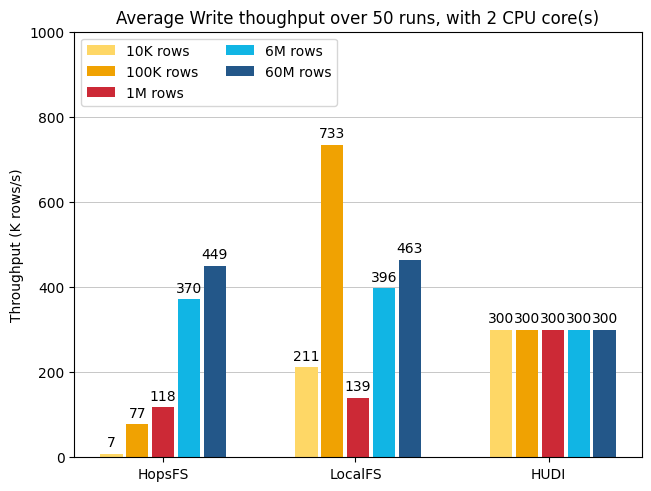

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HDFS,4_core,results_supplier_tpch_sf1,8235.000007,8134.259733,8318.380741
1,HDFS,4_core,results_supplier_tpch_sf10,74932.296288,74182.828858,75711.674576
2,HDFS,4_core,results_supplier_tpch_sf100,119437.691960,116958.554112,121737.251229
3,HDFS,4_core,results_lineitem_tpch_sf1,372641.147479,363693.752613,382034.581354
4,HDFS,4_core,results_lineitem_tpch_sf10,486487.701611,476410.337733,496543.060702
5,LocalFS,4_core,results_supplier_tpch_sf1,226085.571360,214622.755841,237714.512873
6,LocalFS,4_core,results_supplier_tpch_sf10,764667.889724,745439.991904,782169.895794
7,LocalFS,4_core,results_supplier_tpch_sf100,140247.306367,136765.966779,143448.205501
8,LocalFS,4_core,results_lineitem_tpch_sf1,416317.252559,405044.881535,427945.097918
9,LocalFS,4_core,results_lineitem_tpch_sf10,497109.485948,487434.988819,507186.985008


/var/folders/3c/24cqpr7x4nl8cq9mscs0jtbm0000gp/T/ipykernel_70609/2765757706.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


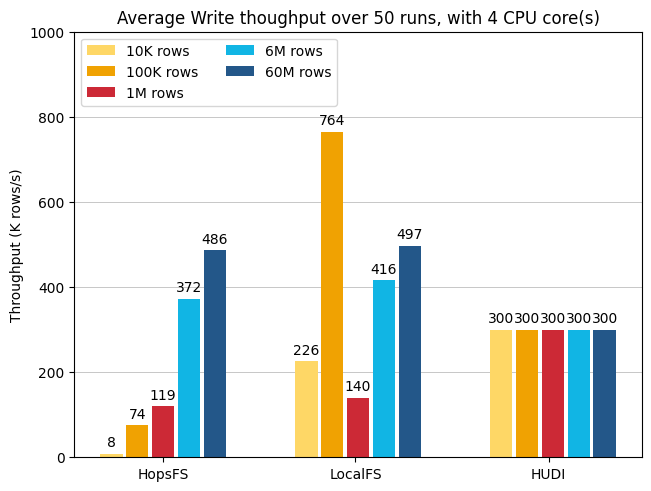

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HDFS,8_core,results_supplier_tpch_sf1,7812.926833,7499.899861,8022.489532
1,HDFS,8_core,results_supplier_tpch_sf10,77921.116236,76420.871730,80372.076553
2,HDFS,8_core,results_supplier_tpch_sf100,121030.849485,118814.691321,123110.940931
3,HDFS,8_core,results_lineitem_tpch_sf1,385339.161837,374370.062176,396488.551674
4,HDFS,8_core,results_lineitem_tpch_sf10,494578.636887,485311.101552,504427.889426
5,LocalFS,8_core,results_supplier_tpch_sf1,235629.481047,223675.080237,248371.519636
6,LocalFS,8_core,results_supplier_tpch_sf10,740685.741899,719292.124763,759313.226765
7,LocalFS,8_core,results_supplier_tpch_sf100,139375.493635,136297.638064,142063.589564
8,LocalFS,8_core,results_lineitem_tpch_sf1,424271.132789,412525.781850,436799.456522
9,LocalFS,8_core,results_lineitem_tpch_sf10,502291.508034,492963.805284,512173.081685


/var/folders/3c/24cqpr7x4nl8cq9mscs0jtbm0000gp/T/ipykernel_70609/2765757706.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])


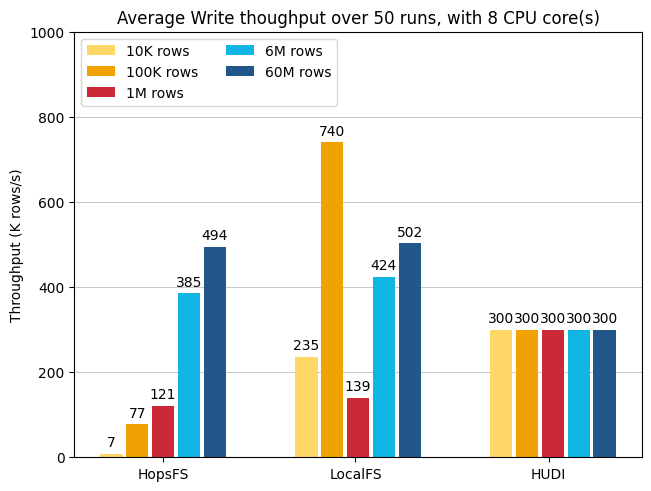

In [227]:
import matplotlib.pyplot as plt
import numpy as np

# Read csv file
df = pd.read_csv("/Users/gio-hopsworks/Developer/thesis-results/data/write_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[df["CPU_Cores"] == CPU_config].copy().reset_index(drop=True)
    
    display(df_filtered)

    technologies = ("HopsFS", "LocalFS", "HUDI")
    write_means = {
        '10K rows':   (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5], 300000),
        '100K rows':  (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6], 300000),
        '1M rows': (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7], 300000),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8], 300000),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9], 300000),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars
    
    width = 0.13  # the width of the bars
    group_offsets = [-0.3, -0.15, 0, 0.15, 0.3]  # offsets for each bar
    np_offsets = np.array([0, 0.115, 0.235])

    fig, ax = plt.subplots(layout='constrained')

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: f'{int(x / 1000)}', padding=3)
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Throughput (K rows/s)')
    ax.set_title('Average Write thoughput over 50 runs, with ' + CPU_config.replace('_', ' CPU ') + '(s)')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper left', ncols=2)
    ax.set_ylim(0, 1000000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([f'{int(x / 1000)}'.format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)

    plt.show()

### Read Operations

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HDFS,1_core,results_supplier_tpch_sf1,3.306242e+05,3.092647e+05,3.522040e+05
1,HDFS,1_core,results_supplier_tpch_sf10,3.233949e+06,3.045030e+06,3.430538e+06
2,HDFS,1_core,results_supplier_tpch_sf100,3.526753e+07,3.305998e+07,3.749693e+07
3,HDFS,1_core,results_lineitem_tpch_sf1,1.890518e+08,1.770155e+08,2.019524e+08
4,HDFS,1_core,results_lineitem_tpch_sf10,1.929321e+09,1.829718e+09,2.039060e+09
5,LocalFS,1_core,results_supplier_tpch_sf1,1.731609e+07,1.640649e+07,1.819844e+07
6,LocalFS,1_core,results_supplier_tpch_sf10,1.803517e+08,1.729425e+08,1.874830e+08
7,LocalFS,1_core,results_supplier_tpch_sf100,1.840742e+09,1.771859e+09,1.904226e+09
8,LocalFS,1_core,results_lineitem_tpch_sf1,9.900668e+09,9.389555e+09,1.036215e+10
9,LocalFS,1_core,results_lineitem_tpch_sf10,6.011102e+10,5.107309e+10,6.866762e+10


/var/folders/3c/24cqpr7x4nl8cq9mscs0jtbm0000gp/T/ipykernel_70609/1235734698.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000000)}'.format(x) for x in current_values])


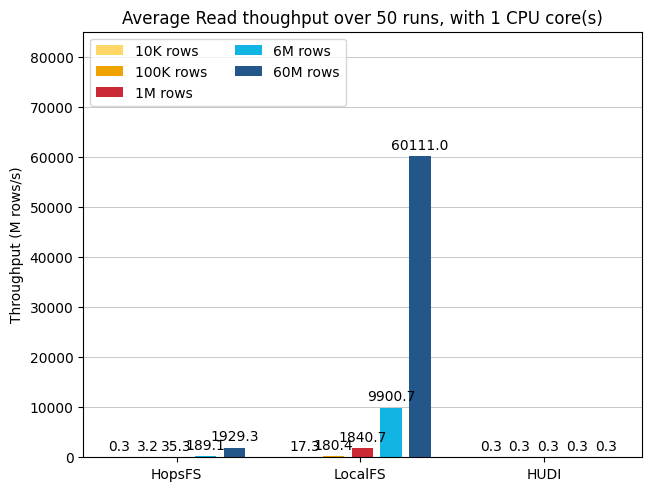

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HDFS,2_core,results_supplier_tpch_sf1,3.221538e+05,3.032372e+05,3.396180e+05
1,HDFS,2_core,results_supplier_tpch_sf10,3.696837e+06,3.499125e+06,3.882298e+06
2,HDFS,2_core,results_supplier_tpch_sf100,3.455219e+07,3.252851e+07,3.657060e+07
3,HDFS,2_core,results_lineitem_tpch_sf1,2.061597e+08,1.913307e+08,2.197965e+08
4,HDFS,2_core,results_lineitem_tpch_sf10,1.969130e+09,1.865274e+09,2.084007e+09
5,LocalFS,2_core,results_supplier_tpch_sf1,1.789566e+07,1.696033e+07,1.870123e+07
6,LocalFS,2_core,results_supplier_tpch_sf10,1.836838e+08,1.751517e+08,1.909443e+08
7,LocalFS,2_core,results_supplier_tpch_sf100,1.724244e+09,1.635447e+09,1.817750e+09
8,LocalFS,2_core,results_lineitem_tpch_sf1,9.913568e+09,9.464430e+09,1.032891e+10
9,LocalFS,2_core,results_lineitem_tpch_sf10,7.752000e+10,7.353114e+10,8.116303e+10


/var/folders/3c/24cqpr7x4nl8cq9mscs0jtbm0000gp/T/ipykernel_70609/1235734698.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000000)}'.format(x) for x in current_values])


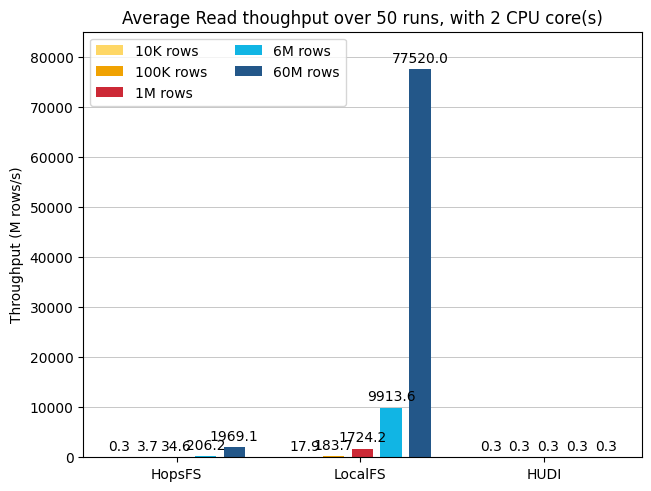

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HDFS,4_core,results_supplier_tpch_sf1,3.702836e+05,3.485527e+05,3.904118e+05
1,HDFS,4_core,results_supplier_tpch_sf10,3.538819e+06,3.307988e+06,3.770171e+06
2,HDFS,4_core,results_supplier_tpch_sf100,3.349049e+07,3.160432e+07,3.549662e+07
3,HDFS,4_core,results_lineitem_tpch_sf1,2.040794e+08,1.920142e+08,2.158378e+08
4,HDFS,4_core,results_lineitem_tpch_sf10,2.055934e+09,1.936122e+09,2.176936e+09
5,LocalFS,4_core,results_supplier_tpch_sf1,1.874082e+07,1.795910e+07,1.944665e+07
6,LocalFS,4_core,results_supplier_tpch_sf10,1.802955e+08,1.724615e+08,1.867227e+08
7,LocalFS,4_core,results_supplier_tpch_sf100,1.880423e+09,1.810182e+09,1.949731e+09
8,LocalFS,4_core,results_lineitem_tpch_sf1,9.685786e+09,9.206481e+09,1.009548e+10
9,LocalFS,4_core,results_lineitem_tpch_sf10,7.075336e+10,6.496373e+10,7.595362e+10


/var/folders/3c/24cqpr7x4nl8cq9mscs0jtbm0000gp/T/ipykernel_70609/1235734698.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000000)}'.format(x) for x in current_values])


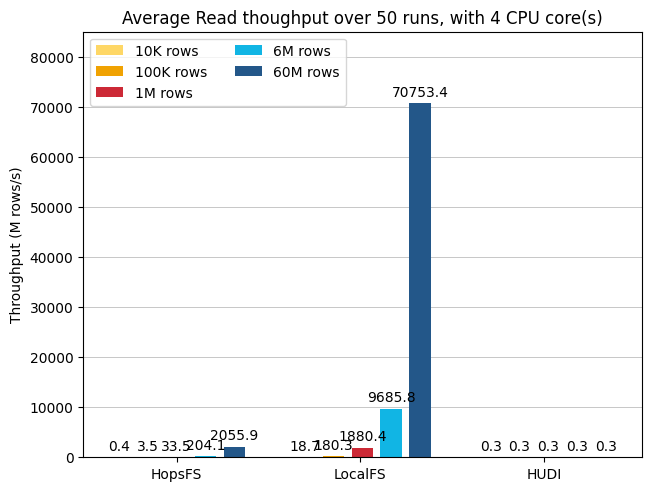

,Technology,CPU_Cores,Table_name,Mean,Low_CI,High_CI
0,HDFS,8_core,results_supplier_tpch_sf1,3.359407e+05,3.073168e+05,3.601433e+05
1,HDFS,8_core,results_supplier_tpch_sf10,3.794785e+06,3.625385e+06,3.950247e+06
2,HDFS,8_core,results_supplier_tpch_sf100,3.386726e+07,3.200422e+07,3.575888e+07
3,HDFS,8_core,results_lineitem_tpch_sf1,2.106351e+08,1.987714e+08,2.227738e+08
4,HDFS,8_core,results_lineitem_tpch_sf10,1.894382e+09,1.782111e+09,2.004906e+09
5,LocalFS,8_core,results_supplier_tpch_sf1,1.756514e+07,1.657250e+07,1.855894e+07
6,LocalFS,8_core,results_supplier_tpch_sf10,1.714057e+08,1.623562e+08,1.804046e+08
7,LocalFS,8_core,results_supplier_tpch_sf100,1.741001e+09,1.641578e+09,1.829867e+09
8,LocalFS,8_core,results_lineitem_tpch_sf1,9.257694e+09,8.807094e+09,9.686018e+09
9,LocalFS,8_core,results_lineitem_tpch_sf10,6.461338e+10,5.788795e+10,7.127731e+10


/var/folders/3c/24cqpr7x4nl8cq9mscs0jtbm0000gp/T/ipykernel_70609/1235734698.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x / 1000000)}'.format(x) for x in current_values])


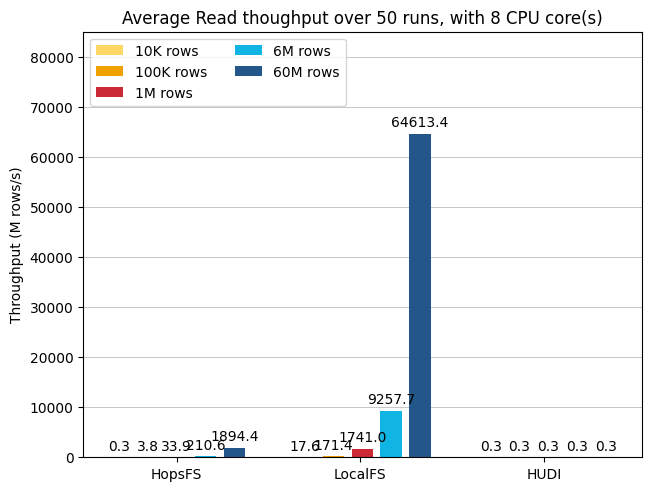

In [233]:
import matplotlib.pyplot as plt
import numpy as np

# Read csv file
df = pd.read_csv("/Users/gio-hopsworks/Developer/thesis-results/data/read_results.csv")
 
for CPU_config in CPU_configs:
    df_filtered = df.loc[df["CPU_Cores"] == CPU_config].copy().reset_index(drop=True)
    
    display(df_filtered)

    technologies = ("HopsFS", "LocalFS", "HUDI")
    write_means = {
        '10K rows':   (df_filtered["Mean"].iloc[0], df_filtered["Mean"].iloc[5], 300000),
        '100K rows':  (df_filtered["Mean"].iloc[1], df_filtered["Mean"].iloc[6], 300000),
        '1M rows': (df_filtered["Mean"].iloc[2], df_filtered["Mean"].iloc[7], 300000),
        '6M rows':   (df_filtered["Mean"].iloc[3], df_filtered["Mean"].iloc[8], 300000),
        '60M rows':  (df_filtered["Mean"].iloc[4], df_filtered["Mean"].iloc[9], 300000),
    }

    bar_colors = ['#FED766', '#F0A202', '#CC2936', '#11B5E4', '#235789'] # New colors for the bars

    width = 0.13  # the width of the bars
    group_offsets = [-0.35, -0.175, 0, 0.175, 0.35]  # offsets for each bar
    np_offsets = np.array([0, 0.115, 0.235])

    fig, ax = plt.subplots(layout='constrained')

    for multiplier, (attribute, measurement) in enumerate(write_means.items()):
        x = np.arange(len(technologies)) + group_offsets[multiplier]  # calculate x values for each group
        offsets = [width * offset for offset in range(len(measurement))]
        rects = ax.bar([x_val + offset for x_val, offset in zip(x, offsets)], measurement, width, label=attribute, color=bar_colors[multiplier])
        ax.bar_label(rects, fmt= lambda x: "{:.1f}".format(float(x / 1000000)), padding=3)
        multiplier += 1

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Throughput (M rows/s)')
    ax.set_title('Average Read thoughput over 50 runs, with ' + CPU_config.replace('_', ' CPU ') + '(s)')
    ax.set_xticks(np.arange(len(technologies)) + np_offsets, technologies)
    ax.legend(loc='upper left', ncols=2)
    ax.set_ylim(0, 85000000000)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([f'{int(x / 1000000)}'.format(x) for x in current_values])
    ax.set_axisbelow(True)
    ax.grid(axis='y', linewidth=0.5)

    plt.show()